In [15]:
import numpy as np
from spec import *
from ifproc import *
from spec_viewer import *
from beam import *
from beam_viewer import *



In [22]:
# set all parameters to control the reduction and plot                                                                   
obsnum = 78085
pixel_number = 10
tsys = 150.

# designate pixels for the BS reduction                                                                                  
list_of_pixels = [8,10]

roach_list = create_roach_list(list_of_pixels)
use_calibration = True
baseline_order = 0
baseline_list = [[-200,-20],[20,200]]
line_integral_list = [[-20,20]]
plot_limits = [-200,200,-1,10]


In [23]:
# look up files to match pixel list                                                                                      
files,nfiles = lookup_roach_files(obsnum,roach_list)
ifproc_file = lookup_ifproc_file(obsnum)

# create the spec_bank object.  This reads all the roaches in the list "files"                                           
I = ifproc_data(ifproc_file)
S = spec_bank_data(files,I,pixel_list=list_of_pixels)


found roach2_78085_0_1_CHI-Cyg_2018-06-29_041715.nc
found ifproc_2018-06-29_078085_00_0001.nc
TRACKING Sequoia PIXEL  10
/data_lmt/ifproc/ifproc_2018-06-29_078085_00_0001.nc does not have map parameters
78085 is a Bs observation
read_roach /data_lmt/spectrometer/roach2/roach2_78085_0_1_CHI-Cyg_2018-06-29_041715.nc


In [24]:
# check whether to use calibration and open necessary file                                                               
if use_calibration == True:
    S.cal_flag = False
    calobsnum = S.calobsnum
    cal_files,ncalfiles = lookup_roach_files(calobsnum,roach_list)
    ifproc_cal_file = lookup_ifproc_file(calobsnum)
    ICal = ifproc_cal(ifproc_cal_file)
    SCal = spec_bank_cal(cal_files,ICal,pixel_list=list_of_pixels)
    check_cal = SCal.test_cal(S)
    if check_cal > 0:
        print('WARNING: CAL MAY NOT BE CORRECT')

    # reduce the two spectra - calibrated                                                                                
    S.roach[0].reduce_ps_spectrum(type=2,calibrate=True,tsys_spectrum=SCal.roach[0].tsys_spectrum)
    S.roach[1].reduce_ps_spectrum(type=2,normal_ps=False,calibrate=True,tsys_spectrum=SCal.roach[1].tsys_spectrum)

else:
    # reduce the two spectra - uncalibrated                                                                              
    S.roach[0].reduce_ps_spectrum(type=2,calibrate=False)
    S.roach[1].reduce_ps_spectrum(type=2,normal_ps=False,calibrate=False)


found roach2_78082_0_1_CHI-Cyg_2018-06-29_041351.nc
found ifproc_2018-06-29_078082_00_0001.nc
TRACKING Sequoia PIXEL  10
/data_lmt/ifproc/ifproc_2018-06-29_078082_00_0001.nc does not have map parameters
/data_lmt/ifproc/ifproc_2018-06-29_078082_00_0001.nc does not have bs parameters
78082 is a Cal observation
read_roach /data_lmt/spectrometer/roach2/roach2_78082_0_1_CHI-Cyg_2018-06-29_041351.nc


In [25]:
# set the baseline channels from velocities                                                                              
blist,nb = S.make_velocity_list(baseline_list,id='baseline')
# set the line integration channels from velocities                                                                      
clist,nc = S.make_velocity_list(line_integral_list,id='line')



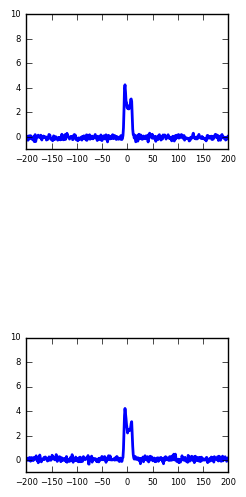

In [26]:
v = S.create_velocity_scale()

pl.figure(1,figsize=(12,8))
plot_order = [1,5,9,13,2,6,10,14,3,7,11,15,4,8,12,16];
for ipix in range(S.npix):
    pixel_id = S.roach_pixel_ids[ipix]
    ax = pl.subplot(4,4,plot_order[pixel_id])
    ax.tick_params(axis='both',which='major',labelsize=6)
    ax.tick_params(axis='both',which='minor',labelsize=6)
    if use_calibration:
        pl.plot(v,S.roach[ipix].ps_spectrum)
        pl.axis(plot_limits)
    else:
        pl.plot(v,S.roach[ipix].ps_spectrum*tsys)
        pl.axis(plot_limits)


BS PIX0= 8 PIX1=10 YMAX=4.214 CMAX=1010 XMAX=-4.715 YINT=49.894 YERR=0.604 XMEAN=1.397 XWIDTH=11.841 RMS=0.094


[-100, 100, -1, 10]

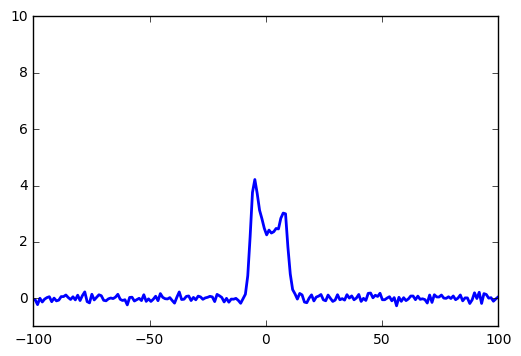

In [27]:
if use_calibration:
    # calibration has been applied                                                                                       
    theSpectrum = (S.roach[0].ps_spectrum+S.roach[1].ps_spectrum)/2.
else:
    # calibration not applied, so multiply by tsys                                                                       
    theSpectrum = (S.roach[0].ps_spectrum+S.roach[1].ps_spectrum)/2. * tsys
line_stat = S.roach[0].line_statistics(S.roach[0],
                                       v,
                                       theSpectrum,
                                       clist,nc,
                                       blist,nb,baseline_order)
print('BS PIX0=%2d PIX1=%2d YMAX=%.3f CMAX=%d XMAX=%.3f YINT=%.3f YERR=%.3f XMEAN=%.3f XWIDTH=%.3f RMS=%.3f'%(S.roach_pi\
xel_ids[0],S.roach_pixel_ids[1],line_stat.ymax,line_stat.cmax,line_stat.xmax,line_stat.yint,line_stat.yerr,line_stat.xme\
an,line_stat.xwidth,line_stat.rms))
pl.plot(line_stat.v,line_stat.spectrum)
pl.axis([-100,100,-1,10])
